In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from scipy.ndimage.filters import maximum_filter1d
from scipy.ndimage.filters import gaussian_filter1d

from matplotlib import pyplot as plt
import os

In [7]:
# data visualization module
from datavyz import gen as ge

In [8]:

preprocessing_params = {
    # fraction to be multiplied to neurpil for substraction from contaminated fluorescence
    'fraction_of_substracted_neuropil':0.7, # unitless
    # threshold to be applied 
    'percentile_threshold_for_baseline': 20, # unitless
    # acquisition frequency
    'freq_acq' : 30., # Hz
    # window length for calculating delta F over F
    'sliding_window_for_baseline' : 30, # seconds
    # factor that the Ca-trace of a cell should exceed wrt to neuropil signal to be classified as a cell
    'fluo_factor_wrt_neuropil_for_inclusion':1.5, # unitless
}

data_directory = '/home/yann/Downloads/Ca_data/'

folders  = [os.path.join(data_directory, d) for d in os.listdir(data_directory)]
print('Data available in the directory: "%s"' % data_directory)
for i, f in enumerate(os.listdir(data_directory)):
    print('%i) %s' % (i+1, f))


Data available in the directory: "/home/yann/Downloads/Ca_data/"
1) TSeries-061119_58-0087-002
2) TSeries-061119_58-0001-001


In [9]:

def load_data_from_folder(folder,
                          soft_prefix='suite2p',
                          plane_prefix='plane0'):

    data = {}
    for key in ['F', 'stat', 'iscell', 'Fneu']:
        data[key] = np.load(os.path.join(folder, soft_prefix, plane_prefix, '%s.npy' % key), allow_pickle=True)

    return data


def from_raw_data_to_deltaFoverF(folder,
                                 fraction_of_substracted_neuropil=0.7,
                                 percentile_threshold_for_baseline=0.7,
                                 freq_acq=30.,
                                 sliding_window_for_baseline = 30.,
                                 fluo_factor_wrt_neuropil_for_inclusion = 1.5,
                                 verbose=False):

    if verbose:
        data = load_data_from_folder(folder)
        print(' data from: "%s" succesfully loaded ' % folder)

    print('----> Pre-processing the fluorescence of n=%i cells across n=%i time samples' % data['F'].shape)
    if verbose:
        print(' 1) [...] applying the ROI selection and the neuropil criteria')
    neuropil_cond = (np.mean(data['F'], axis=1)<fluo_factor_wrt_neuropil_for_inclusion*np.mean(data['Fneu'], axis=1))
    iscell = np.array(data['iscell'][:,0], dtype=bool) & neuropil_cond
    data['fluo_valid_cells'] = data['F'][iscell,:]
        
    if verbose:
        print(' 2) [...] substracting neuropil contamination')
    data['fluo_valid_cells'] -= fraction_of_substracted_neuropil*data['Fneu'][iscell,:]

    if verbose:
        print(' 3) [...] calculating sliding baseline per cell')
    Twidth = int(sliding_window_for_baseline*freq_acq) # window in sample units 
    # sliding minimum using the max filter of scipy, followed by gaussian smoothing
    data['sliding_min'] = gaussian_filter1d(-maximum_filter1d(-data['fluo_valid_cells'],
                                                              size=Twidth), Twidth)
    if verbose:
        print(' 4) [...] performing DeltaF/F normalization')
    data['dFoF'] = np.divide((data['fluo_valid_cells']-data['sliding_min']),data['sliding_min'])

    # some useful quantites
    data['t'] = np.arange(int(data['fluo_valid_cells'].shape[1]))/freq_acq # time axis

    # formatted data
    Data = {}
    data['mean_Data'], data['std_Data'], data['norm_Data'] = {}, {}, {}
    
    for i in range(data['fluo_valid_cells'].shape[0]):
        key = 'cell%i' % (i+1)
        Data[key] = data['dFoF'][i, :]
        data['mean_Data'][key] = Data[key].mean()
        data['std_Data'][key] = Data[key].std()
        data['norm_Data'][key] = (Data[key]-Data[key].mean())/Data[key].std()
    if verbose:
        print('----> Pre-processing done !')

    return data, Data


In [10]:
data, Data = from_raw_data_to_deltaFoverF(folders[0], **preprocessing_params,
                                          verbose=True)

 data from: "/home/yann/Downloads/Ca_data/TSeries-061119_58-0087-002" succesfully loaded 
----> Pre-processing the fluorescence of n=173 cells across n=9074 time samples
 1) [...] applying the ROI selection and the neuropil criteria
 2) [...] substracting neuropil contamination
 3) [...] calculating sliding baseline per cell
 4) [...] performing DeltaF/F normalization
----> Pre-processing done !


# visualizing pre-processing

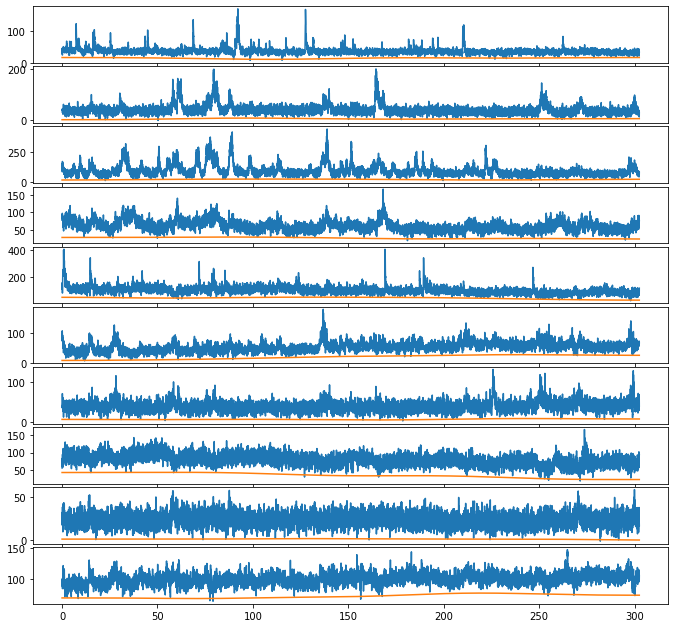

In [11]:
n = 10
fig, AX = ge.figure(axes=(1, n), figsize=(2,.5), hspace=0.1)
for i, ax in enumerate(AX):
    ax.plot(data['t'], data['fluo_valid_cells'][i,:])
    ax.plot(data['t'], data['sliding_min'][i,:])    

In [12]:

def activity_plot(Data,
                  Data_original=None, t=None,
                  tzoom=[0, np.inf],
                  colors = None,
                  ax=None, bar_fraction=0.7, Tbar=10, lw=0.5):
    
    if ax is None:
        _, ax = ge.figure(axes_extents=(4,4))

    if colors is None:
        colors = [ge.colors[i%10] for i, k in enumerate(Data)]
        
    keys = [key for key in Data]
    if t is None:
        t = np.arange(len(Data[keys[0]]))
    t_cond = (t>=tzoom[0]) & (t>=tzoom[0])

    for i, key in enumerate(Data):
        if Data_original is not None:
            norm_factor = 1./(np.max(Data_original[key][t_cond])-np.min(Data_original[key][t_cond]))
            baseline = np.min(Data_original[key][t_cond])
            norm_Data_original = (Data_original[key][t_cond]-baseline)*norm_factor
            ax.plot(t[t_cond], i+norm_Data_original, colors[i], lw=0.2, alpha=.3)
        else:
            norm_factor = 1./(np.max(Data[key][t_cond])-np.min(Data[key][t_cond]))
            baseline = np.min(Data[key][t_cond]) 
           
        norm_Data = norm_factor*(Data[key][t_cond]-baseline)

        ax.plot(t[t_cond], i+norm_Data, colors[i], lw=lw)
        ge.annotate(ax, key, (t[t_cond][-1], i+1), color=colors[i],
                    xycoords='data', ha='right', size='small', va='top')
        
        # scale for that cell
        ax.plot([0, 0], [i, i+bar_fraction], color=ge.default_color)
        if 100.*norm_factor<1:
            ge.annotate(ax, '%.1f%%' % (100.*norm_factor),
                    (0, i), rotation=90, xycoords='data', ha='right', size='small')
        else:
            ge.annotate(ax, '%i%%' % int(100.*norm_factor),
                    (0, i), rotation=90, xycoords='data', ha='right', size='small')
        
    ax.plot([0, Tbar], [i+1, i+1], color=ge.default_color)
    ge.annotate(ax, '%is' % Tbar, (0, i+1), xycoords='data', size='small')
    
    ax.axis('off')


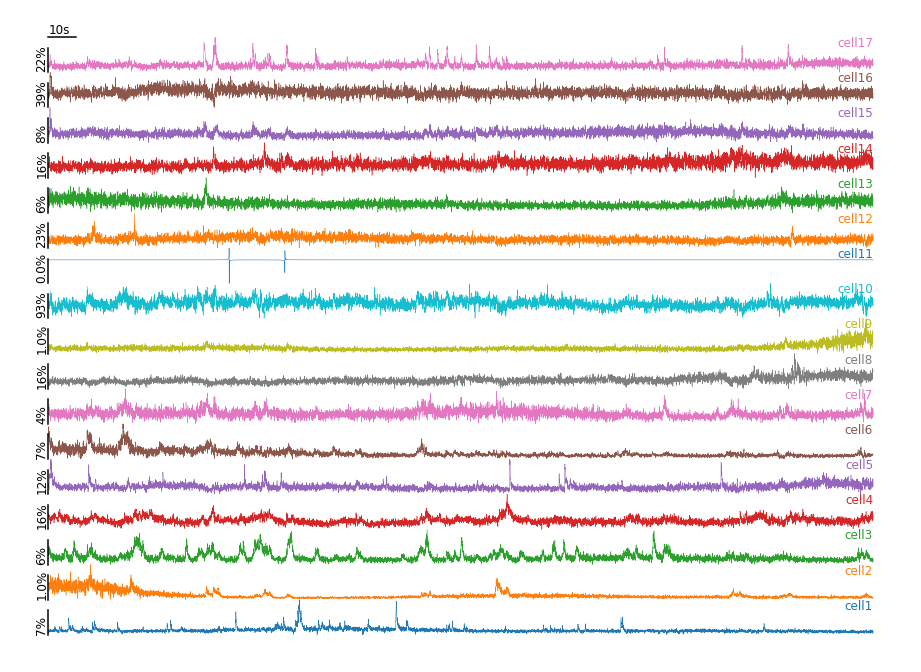

In [13]:
activity_plot(Data, Tbar=10, t=data['t']);

In [14]:
from sklearn.decomposition import PCA as sklPCA

def PCA(data,
        n_components=2, desired_var_explained=None):

    if desired_var_explained is not None:
        pca = sklPCA(n_components=desired_var_explained)
    else:
        pca = sklPCA(n_components=n_components)

    X = np.array([data[key] for key in data]).T # insuring shape (n_samples, n_features)
    pca.fit(X) 

    return pca


# run PCA
pca = PCA(data['norm_Data'], n_components = len(Data)) # desired_var_explained=0.9)       

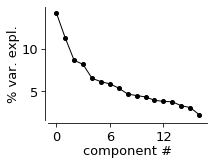

In [15]:
# let's plot the variance explained by the components
ge.plot(100.*pca.explained_variance_ratio_,
         m='o', ms=4, xlabel='component #', ylabel='% var. expl.');

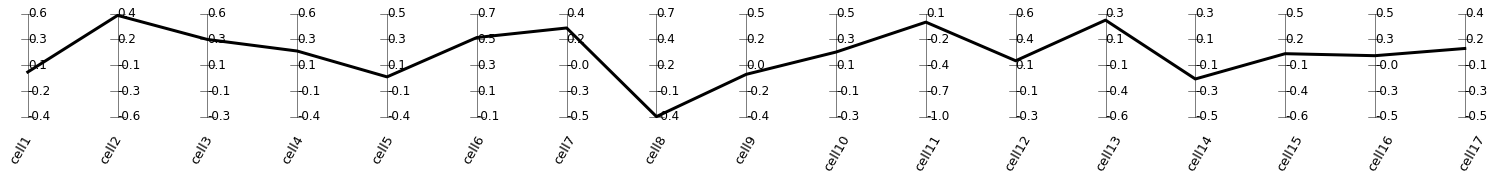

In [16]:
# visualizing the component
# -> visualizing the comodulation pattern corresponding to a component

i0, i1 = 0, 1
ge.parallel_plot(pca.components_[i0:i1],
                 SET_OF_LIMS=[[pca.components_[:,i].min(), pca.components_[:,i].max()] for i in range(len(Data))],
                 # SET_OF_LIMS=[[-1, 1] for i in range(len(Data))],
                 SET_OF_LABELS=list(Data.keys()), lw=3,
                 tick_number = 5, tick_size=0.01, 
                 fig_args=dict(figsize=(2,1), bottom=.5, left=.5, right=2.),
                 label_annotation_args=dict(va='top', ha='center',rotation=60.));

In [17]:
# see the output of the first component
pca = PCA(data['norm_Data'], n_components = 1)
X = np.array([data['norm_Data'][key] for key in Data]).T # insuring shape (n_samples, n_features)
X_new = pca.fit_transform(X)
X1 = pca.inverse_transform(X_new)
pc1_Data = {}
for i, key in enumerate(Data):
    pc1_Data[key] = X1[:,i]*data['std_Data'][key]+data['mean_Data'][key]


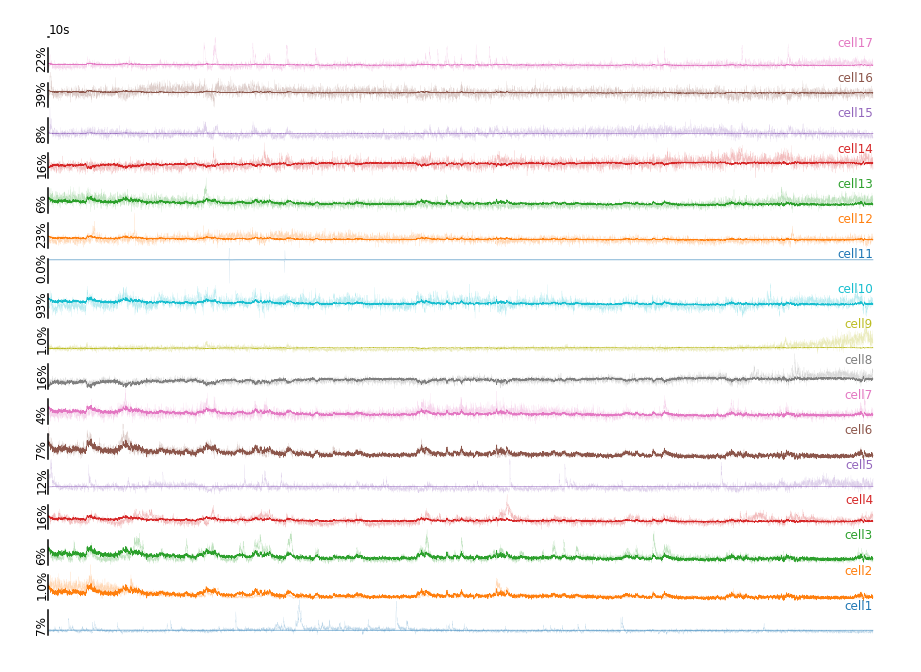

In [18]:
activity_plot(pc1_Data, Data_original=Data)

In [19]:
# see the output of the second component
pca = PCA(data['norm_Data'], n_components = 2)
X = np.array([data['norm_Data'][key] for key in Data]).T # insuring shape (n_samples, n_features)
X_new = pca.fit_transform(X)
X2 = pca.inverse_transform(X_new)
pc2_Data = {}
for i, key in enumerate(Data):
    pc2_Data[key] = (X2[:,i]-X1[:,i])*data['std_Data'][key]+data['mean_Data'][key]


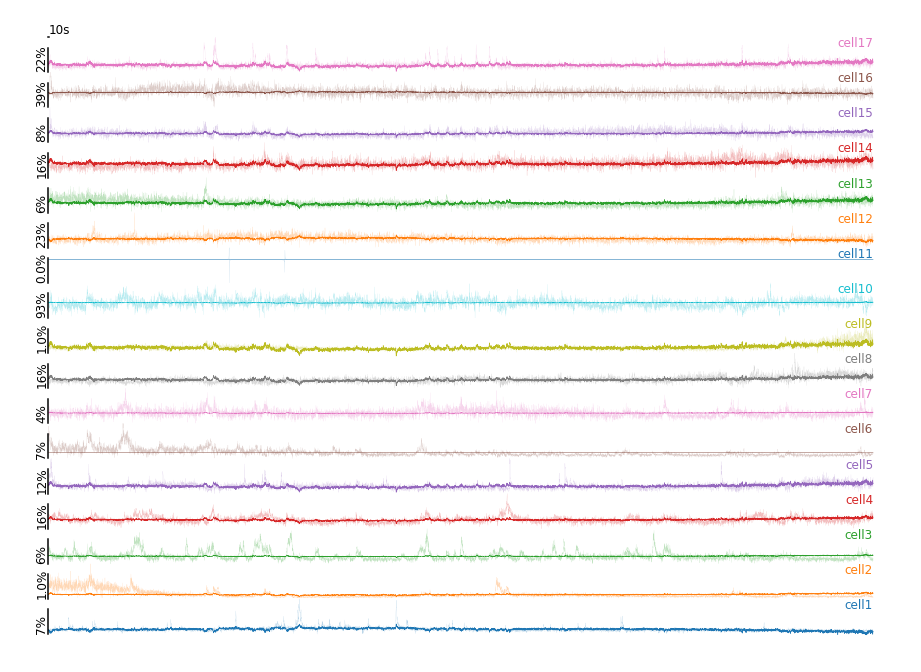

In [20]:
activity_plot(pc2_Data, Data_original=Data)

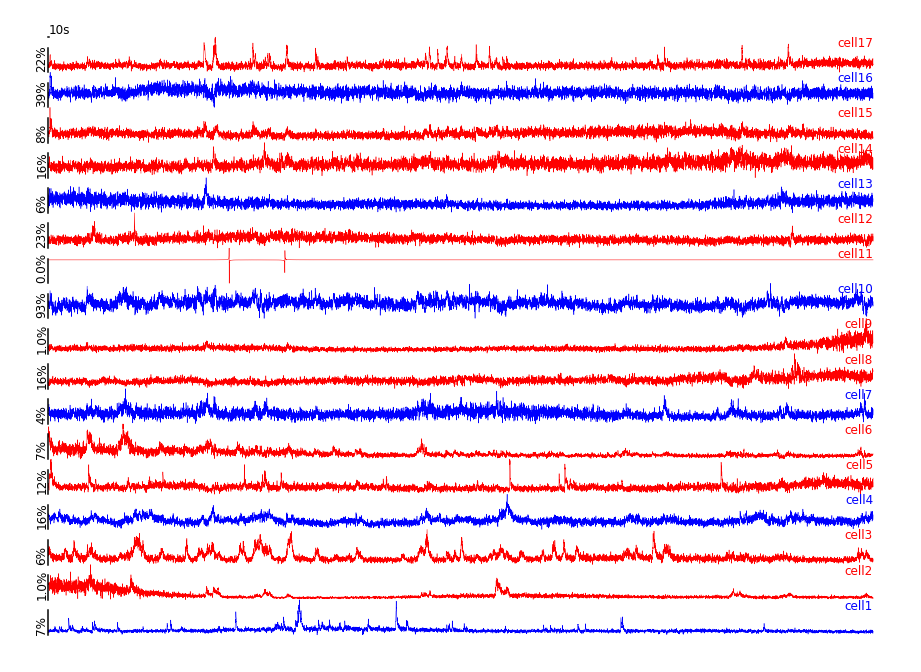

In [21]:


colors = ['red' if (i%3) else 'blue'  for i, _ in enumerate(Data)]
# using colors
activity_plot(Data, colors=colors)


In [65]:
# calculating delta Fover F
df  = meandelFoverF(Fluo,window_length,percentile_threshold)

# Calculating two Principal components
pc = pc_calculation(df)
pc1_normfactor = np.max(np.abs(pc[:,0]))
pc2_normfactor = np.max(np.abs(pc[:,1]))

pc[:,0] = pc[:,0]/pc1_normfactor
pc[:,1] = pc[:,1]/pc2_normfactor

In [66]:
# Calculating labels for 3 clusters
kmeans = KMeans(n_clusters = 3, random_state=0).fit(pc)

# Extracting values belonging to one of the three classes
class1 = kmeans.labels_==0
class2 = kmeans.labels_==1
class3 = kmeans.labels_==2

class1 = pc[class1]
class2 = pc[class2]
class3 = pc[class3]

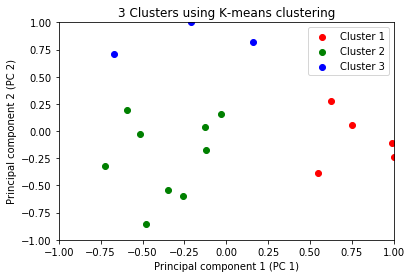

In [67]:
# Plotting of the clusters

fig1 = plt.figure(1)

plt.title("3 Clusters using K-means clustering")
plt.xlabel("Principal component 1 (PC 1)")
plt.ylabel("Principal component 2 (PC 2)")

plt.ylim(-1,1)
plt.xlim(-1,1)

plt.scatter(class1[:,0],class1[:,1], c = 'r', label = 'Cluster 1')
plt.scatter(class2[:,0],class2[:,1], c = 'g', label= 'Cluster 2')
plt.scatter(class3[:,0],class3[:,1], c = 'b', label = 'Cluster 3')

plt.legend(loc = 'upper right')
